In [47]:
import pandas
import feather
import datetime
import numpy
from scipy.optimize import curve_fit
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib import ticker
from matplotlib.ticker import FuncFormatter, MaxNLocator, FormatStrFormatter
from davitpy.models import *
from davitpy import utils
from aacgmv2 import convert_mlt
%matplotlib inline

In [2]:
sizeAsyCutoff = 50.

In [3]:
potDF = feather.read_dataframe('../data/potDF.feather')
# There are too many Asy values, to model 
# we'll round it off to nearest 40. This
# is equivalent to binning.
# Get number of values for different Asy Inds
# discard those values which have low counts
sizeAsyDF = potDF.groupby("AsyH").size().reset_index()
sizeAsyDF.columns = [ "AsyH", "asyCnt" ]
sizeAsyDF = sizeAsyDF[ sizeAsyDF["asyCnt"] >= sizeAsyCutoff]
potDF = pandas.merge(potDF, sizeAsyDF,\
                     on = "AsyH", how="inner"\
                    ).reset_index(drop=True)
potDF["AsyHRnd"] = numpy.round(potDF["AsyH"]/30.)*30.
# Get peak potentials
peakPotDF = potDF[[ "AsyH", "potMagn" ]].groupby( "AsyH" ).max().reset_index()
peakPotDF.columns = [ "AsyH", "peakPotMagn" ]
# Normalize the values of potential
# for every AsyH value. This makes 
# fitting easy!
potDF = pandas.merge( potDF, peakPotDF, on="AsyH" )
potDF["normPot"] = potDF["potMagn"]/potDF["peakPotMagn"]
potDF.head()

,AsyH,MLAT,normMLT,potential,normLAT,potMagn,mlt,asyCnt,AsyHRnd,peakPotMagn,normPot
0,45.0,56.5,-7.0,-2.21,-2.0,2.21,17.0,186,60.0,34.55,0.063965
1,45.0,57.0,-7.0,-3.82,-1.5,3.82,17.0,186,60.0,34.55,0.110564
2,45.0,57.5,-7.0,-5.75,-1.0,5.75,17.0,186,60.0,34.55,0.166425
3,45.0,58.5,-7.0,-7.77,0.0,7.77,17.0,186,60.0,34.55,0.224891
4,45.0,59.0,-7.0,-10.10,0.5,10.10,17.0,186,60.0,34.55,0.292330


In [4]:
# We'll normalize potentials differently here
# We'll find max potentials(magn) at every
# MLT, AsyH index, we can then model MLAT
# dependence at that AsyH,MLT bin.
mltAsyPotDFMax = potDF[ ["AsyHRnd", "normMLT", "potMagn"]\
                ].groupby( ["AsyHRnd", "normMLT"] \
                ).max().reset_index()

mltAsyPotDFMax.columns = [ "AsyHRnd", "normMLT", "max_potMagn" ]
mlatMLTPotDF = potDF[ ["AsyHRnd", "normMLT", "potMagn", "MLAT"]\
                ].groupby( ["AsyHRnd", "normMLT", "MLAT"] \
                ).max().reset_index()

mlatMLTPotDF = pandas.merge( mlatMLTPotDF, mltAsyPotDFMax, on=[ "AsyHRnd", "normMLT" ] )
mlatMLTPotDF["normPot"] = mlatMLTPotDF["potMagn"]/mlatMLTPotDF["max_potMagn"]
# Normalize MLATs
mltLatsDF = potDF[ ["AsyHRnd", "normMLT", "MLAT"]\
                ].groupby( ["AsyHRnd", "normMLT"] \
                ).max().reset_index()
mltLatsDF.columns = [ "AsyHRnd", "normMLT", "max_MLAT" ]
minLatsDF = potDF[ ["AsyHRnd", "normMLT", "MLAT"]\
                ].groupby( ["AsyHRnd", "normMLT"] \
                ).min().reset_index()
minLatsDF.columns = [ "AsyHRnd", "normMLT", "min_MLAT" ]
mltLatsDF = pandas.merge( mltLatsDF, minLatsDF,\
                         on=["AsyHRnd", "normMLT"],\
                         how="inner" )
mltLatsDF["delMLAT"] = mltLatsDF["max_MLAT"] - mltLatsDF["min_MLAT"]
mlatMLTPotDF = pandas.merge( mlatMLTPotDF, mltLatsDF, on=[ "AsyHRnd", "normMLT" ] )
mlatMLTPotDF["normMLAT"] = mlatMLTPotDF["MLAT"] - mlatMLTPotDF["min_MLAT"]
mlatMLTPotDF["normMLAT"] = mlatMLTPotDF["normMLAT"]/mlatMLTPotDF["delMLAT"]

# print mlatMLTPotDF[ mlatMLTPotDF["normMLAT"] == 0 ][ ["AsyHRnd", "normMLT", "MLAT", "normPot", "normMLAT"] ]

In [5]:
# To estimate MLAT variations we
# fit a polynomial function!
def mlat_mlt_fit_func((mlat, normMLT, asy),\
            c0_a, c0_b, c0_c, c1_a, c1_b, c1_c, c2_a, c2_b, c2_c):
    c0 = c0_a + c0_b * asy + c0_c*normMLT
    c1 = c1_a + c1_b * asy + c1_c*normMLT
    c2 = c2_a + c2_b * asy + c2_c*normMLT
    return c0 + c1*mlat + c2*numpy.square(mlat)

# def mlat_mlt_fit_func((mlat, normMLT, asy),\
#             c0_a, c0_b, c0_c, c1, c2):
#     c0 = c0_a + c0_b * asy + c0_c*normMLT
# #     c1 = c1_a + c1_b * asy + c1_c*normMLT
# #     c2 = c2_a + c2_b * asy + c2_c*normMLT
#     return c0 + c1*numpy.exp( mlat*c2 )

In [8]:
mlatMLTPotDF.head()

,AsyHRnd,normMLT,MLAT,potMagn,max_potMagn,normPot,max_MLAT,min_MLAT,delMLAT,normMLAT
0,0.0,-7.0,60.0,0.80,1.44,0.555556,60.5,60.0,0.5,0.000000
1,0.0,-7.0,60.5,1.44,1.44,1.000000,60.5,60.0,0.5,1.000000
2,0.0,-6.0,59.5,0.58,5.70,0.101754,63.0,59.5,3.5,0.000000
3,0.0,-6.0,60.0,1.21,5.70,0.212281,63.0,59.5,3.5,0.142857
4,0.0,-6.0,60.5,1.87,5.70,0.328070,63.0,59.5,3.5,0.285714


In [6]:
poptMlatMLTPot, pcovMlatMLTPot = curve_fit(mlat_mlt_fit_func,\
                               (mlatMLTPotDF['normMLAT'].T,\
                                mlatMLTPotDF['normMLT'].T, mlatMLTPotDF['AsyHRnd'].T),\
                               mlatMLTPotDF['normPot'], p0=(1., 1., 1., 1., 1., 1., 1., 1., 1.))
poptMlatMLTPot = [ round(x,5) for x in poptMlatMLTPot ]
print poptMlatMLTPot

predAsyArr = []
predMlatArr = []
predPotArr = []
predNormMltArr = []

for currAsy in mlatMLTPotDF["AsyHRnd"].unique():
    for currNMLT in mlatMLTPotDF["normMLT"].unique():
        for cpMlat in numpy.arange(0,1.1,0.1):
            predMlatArr.append( cpMlat )
            predAsyArr.append( currAsy )
            predNormMltArr.append( currNMLT )
            # Fit params
            predPotArr.append( mlat_mlt_fit_func(\
                                        (cpMlat, currNMLT,\
                                         currAsy), *poptMlatMLTPot) )
            
    
predMlatMLTPotDF = pandas.DataFrame({
                "predPot" : predPotArr,
                "predMLAT" : predMlatArr,
                "predAsy" : predAsyArr,
                "predNormMlt" : predNormMltArr
                })

[0.05447, 0.00034, 0.00614, 0.75923, 0.00687, 0.05281, 0.18218, -0.00776, -0.0636]


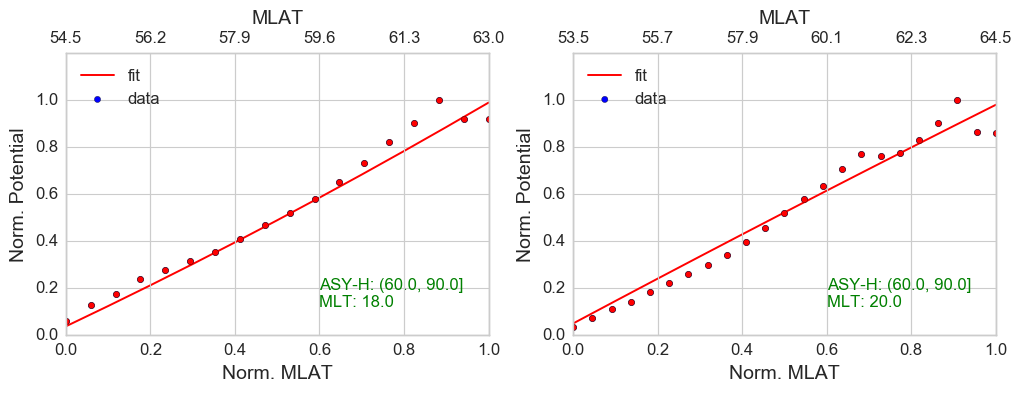

In [52]:
def format_mlt_normMLT_ticks(tick_val, tick_pos):
    if tick_val < 0:
        return str(tick_val + 24)
    else:
        return str(tick_val)

normMLTList = [-6., -4.]#[-6., -4., -2., 2.]#potDF["normMLT"].unique()[1::2]
selAsy = 60.

sns.set_style("whitegrid")
sns.set_context("paper")

f = plt.figure(figsize=(12, 8))
ax = []
ax.append( f.add_subplot(2,2,1) )
ax.append( f.add_subplot(2,2,2) )
# ax.append( f.add_subplot(2,2,3) )
# ax.append( f.add_subplot(2,2,4) )

for mind, currMLT in enumerate(normMLTList):
    subDF1 = mlatMLTPotDF[ (mlatMLTPotDF["normMLT"] == currMLT)&\
                              (mlatMLTPotDF["AsyHRnd"] == selAsy) ]
    subDF2a = predMlatMLTPotDF[ (predMlatMLTPotDF["predNormMlt"] == currMLT) &\
                              (predMlatMLTPotDF["predAsy"] == selAsy) ]
    if currMLT < 0:
        currMLTStr = str( currMLT + 24. )
    else:
        currMLTStr = str( currMLT )
    ax[mind].scatter( subDF1["normMLAT"].values, subDF1["normPot"].values, c="b", label="data" )
    ax[mind].plot( subDF2a["predMLAT"].values, subDF2a["predPot"].values, c="r", label="fit")
    printText = "ASY-H: (" + str(selAsy) + ", " + str(selAsy+30) + "]\nMLT: " + currMLTStr
    ax[mind].text(0.6, 0.1,  printText,
            transform=ax[mind].transAxes,
            color='green', fontsize=12)
    ax[mind].set_xlabel( "Norm. MLAT", fontsize=14 )
    ax[mind].set_ylabel( "Norm. Potential", fontsize=14 )
    ax[mind].set_xlim([0,1.])
    ax[mind].set_ylim([0,1.2])
    # plot another x-axis
    ax2 = ax[mind].twiny()
    ax2.scatter( subDF1["MLAT"].values, subDF1["normPot"].values, c="r", label="data" )
    ax2.set_xlabel('MLAT', fontsize=14)
    ax2.set_xlim([subDF1["MLAT"].min(),subDF1["MLAT"].max()])
    ax2.set_ylim([0,1.2])
    ax2.tick_params(labelsize=12)
    ax[mind].set_xticks(numpy.linspace(ax[mind].get_xbound()[0], ax[mind].get_xbound()[1], 6))
    ax2.set_xticks(numpy.linspace(ax2.get_xbound()[0], ax2.get_xbound()[1], 6))
    ax2.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))

    ax[mind].tick_params(labelsize=12)
    ax[mind].legend()
    ax[mind].xaxis.set_major_formatter(FuncFormatter(format_mlt_normMLT_ticks))
    ax[mind].legend(prop={'size': 12}, loc=2)
plt.savefig("../figs/Pot-MLAT-model.pdf",bbox_inches='tight')